In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom

In [2]:
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2001,MP Pelvis_2001,MP\CT.2.25.122959172090682991274033812218091597619.dcm"
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2001,MP Pelvis_2001,MP\CT.2.25.53134265348401973381541910902006399597.dcm"
data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

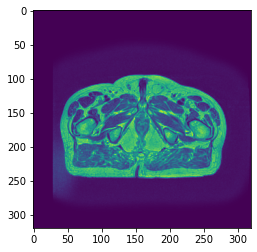

In [3]:
plt.imshow(image)

In [4]:
def c2h(X):
    # Convert cartesian to homogeneous coordinates.
    # Input:
    # X - cartesian coordinates
    # Output:
    # Xh - homogeneous coordinates

    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # Convert a 2D transformation matrix to homogeneous form.
    # Input:
    # T - 2D transformation matrix
    # t - 2D translation vector
    # Output:
    # Th - homogeneous transformation matrix

    #------------------------------------------------------------------#
    # TODO: Implement conversion of a transformation matrix and a translation vector to homogeneous transformation matrix.
    #------------------------------------------------------------------#

    T1 = np.concatenate((T,t[:,None]),axis=1)
    n = np.zeros([1,T1.shape[1]])
    n[-1,-1] = 1
    Th = np.append(T1, n, axis=0)
    
    return Th

def identity():
    # 2D identity matrix.
    # Output:
    # T - transformation matrix

    T = np.eye(2)

    return T

def rotate(phi):
    # 2D rotation matrix.
    # Input:
    # phi - rotation angle
    # Output:
    # T - transformation matrix

    #------------------------------------------------------------------#
    # TODO: Implement transformation matrix for rotation.
    #------------------------------------------------------------------#
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(I, Th,  output_shape=None):
    # Image transformation by inverse mapping.
    # Input:
    # I - image to be transformed
    # Th - homogeneous transformation matrix
    # output_shape - size of the output image (default is same size as input)
    # Output:
    # It - transformed image
	# Xt - remapped coordinates
    # we want double precision for the interpolation, but we want the
    # output to have the same data type as the input - so, we will
    # convert to double and remember the original input type

    input_type = type(I)

    # default output size is same as input
    if output_shape is None:
        output_shape = I.shape

    # spatial coordinates of the transformed image
    x = np.arange(0, output_shape[1])
    y = np.arange(0, output_shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    #------------------------------------------------------------------#
    # TODO: Perform inverse coordinates mapping.
    #------------------------------------------------------------------#

    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    It = ndimage.map_coordinates(I, [Xt[1,:], Xt[0,:]], order=1, mode='constant').reshape(output_shape)

    return It, Xt

def image_transform_test(I, ang_deg, trans_x, trans_y):

    # rotation around the image center
    centre = int(I.shape[0]/2)
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(identity(), centre*np.ones(2))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(identity(), -centre*np.ones(2))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(identity(), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    It, Xt = image_transform(I, T_tot)
    
    return It, Xt

In [5]:
from scipy import ndimage

def motion(image):
    min_init = np.min(image)
    max_init = np.max(image)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    n_movements = np.random.randint(1, 3)
    grid_size = image.shape
    locs = np.sort(np.random.permutation(grid_size[0])[:n_movements])
    ang_std = 1.5
    trans_std = 2.0
    ang = np.random.normal(0, ang_std, (n_movements+1))
    trans_x = np.random.normal(0, trans_std, (n_movements+1))
    trans_y = np.random.normal(0, trans_std, (n_movements+1))
    k_space = transform_image_to_kspace(image)
    ang_tot = ang[0]
    trans_x_tot = trans_x[0]
    trans_y_tot = trans_y[0]
    It_0, Xt_0 = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
    kspace_It_0 = transform_image_to_kspace(It_0)
    k_space[:locs[0] :] = kspace_It_0[:locs[0], :]
    for i in range(n_movements):
        ang_tot += ang[i+1]
        trans_x_tot += trans_x[i+1]
        trans_y_tot += trans_y[i+1]
        It_i, Xt_i = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
        kspace_It_i = transform_image_to_kspace(It_i)
        k_space[locs[i-1]:locs[i], :] = kspace_It_i[locs[i-1]:locs[i], :]
    
    img = transform_kspace_to_image(k_space)
    img = img*(max_init-min_init) + min_init
    img = (img - np.mean(img)) / np.std(img)
    
    return img

In [6]:
def motion2(image):
    min_init = np.min(image)
    max_init = np.max(image)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    k_space = transform_image_to_kspace(image)
    
    trans_x_tot = []
    offset = np.random.uniform(0, 1)*2*np.pi
    trans_std = 2.0
    trans = np.random.normal(0, trans_std)

    for i in range(image.shape[0]):
        offset = np.random.uniform(0, 1)*2*np.pi
        trans_x = trans*(np.sin(offset + (i/image.shape[0])*2*np.pi))
        It_i, Xt_i = image_transform_test(image, 0, 0, trans_x)
        kspace_It_i = transform_image_to_kspace(It_i)
        k_space[i, :] = kspace_It_i[i, :]
    
    img = transform_kspace_to_image(k_space)
    img = img*(max_init-min_init) + min_init
    img = (img - np.mean(img)) / np.std(img)
    
    return img

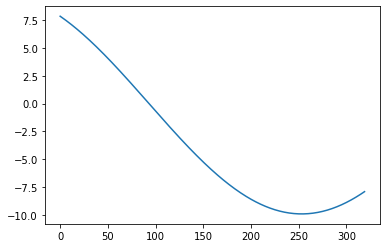

In [7]:
trans_x_tot = []
offset = np.random.uniform(0, 1)*2*np.pi
trans_std = 10.0
trans = np.random.normal(0, trans_std)
for i in range(image.shape[0]):
    trans_x = trans*(np.sin(offset + (i/(2*image.shape[0])*2*np.pi)))
    trans_x_tot.append(trans_x)
plt.plot(trans_x_tot)
plt.show()

(-0.5, 319.5, 319.5, -0.5)

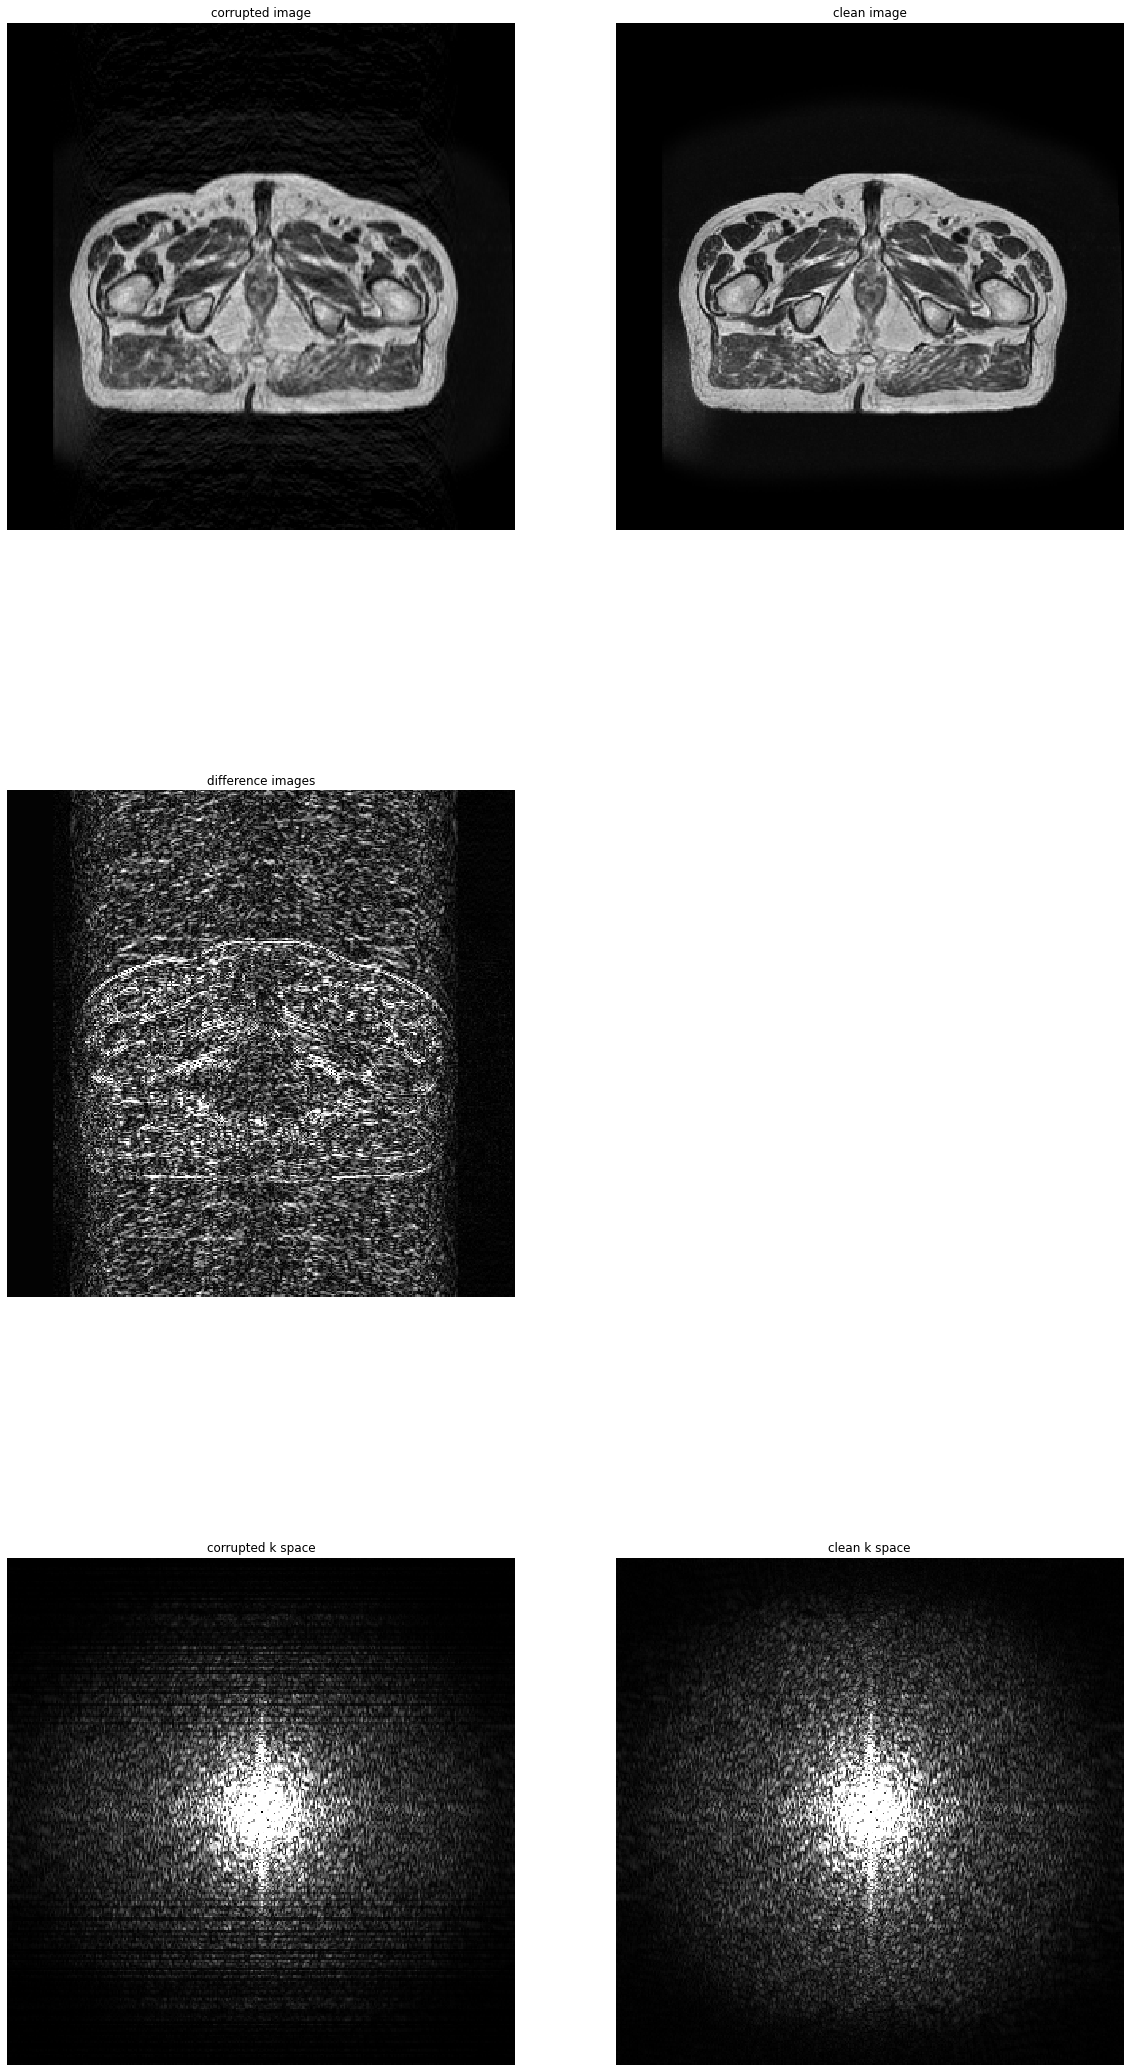

In [8]:
# plotting

img = motion2(image)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [9]:
from sklearn.metrics import mean_squared_error
mean_squared_error(image, img)

0.024926167472366055

In [10]:
kspace = transform_image_to_kspace(image)
kspace.shape

(320, 320)

In [11]:
def simulate_breath_sine(image):
    dim = image.shape
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    # Respiratory Frequency (alpha)
    rHz = 0.1 + 5*np.random.uniform()
    # Shift along PE direction (delta)
    dPos = 0 + 20*np.random.uniform()
    # Phase (beta)
    Phase = (np.pi/4)*np.random.uniform()
    # ky0
    Start = round(0.5*dim[0]);

    # Make periodical motion
    Resp_sig = np.arange(0, image.shape[0])
    Resp_sig = dPos*np.sin(-2*np.pi*rHz*Resp_sig/image.shape[0] + Phase)
    #     Resp_sig((dim(1)-Start-1):end) = 0;
    #     Resp_sig = circshift(Resp_sig, [0 Start]);
    Resp_sig = np.reshape(Resp_sig, (image.shape[0], 1))
    #     Resp_sig(restp) = Resp_sig;

    #     pos_change_x(:,:,jj) = repmat(Resp_sig, [1 size(in,2)]);
    pos_change_x = np.tile(Resp_sig, [1, image.shape[1]])

    # end
    
    # No motion in the center of k-space
    xc_min = round(image.shape[0]/2 - round(0.1*image.shape[0]))
    xc_max = round(image.shape[0]/2 + round(0.1*image.shape[0]))
    pos_change_x[xc_min:xc_max, :] = 0


    # Add phase error to k-space
    y = shift_PE(image, pos_change_x)
    
    y = (y - np.mean(y)) / np.std(y)
   
    #return y, pos_change_x
    return y

In [12]:
def shift_PE(image, posy):
    temp = image
    spect = transform_image_to_kspace(temp)
    x = np.arange(0, image.shape[0])
    y = np.arange(0, image.shape[1])
    xx, yy = np.meshgrid(x, y)
    phasey = (yy - image.shape[1])/2
    phasey = 2*np.pi*posy*phasey/image.shape[1];  
    phase = np.exp(0+phasey*1j)
    spect = spect*phase    
    y = transform_kspace_to_image(spect)  
    return y

(-0.5, 319.5, 319.5, -0.5)

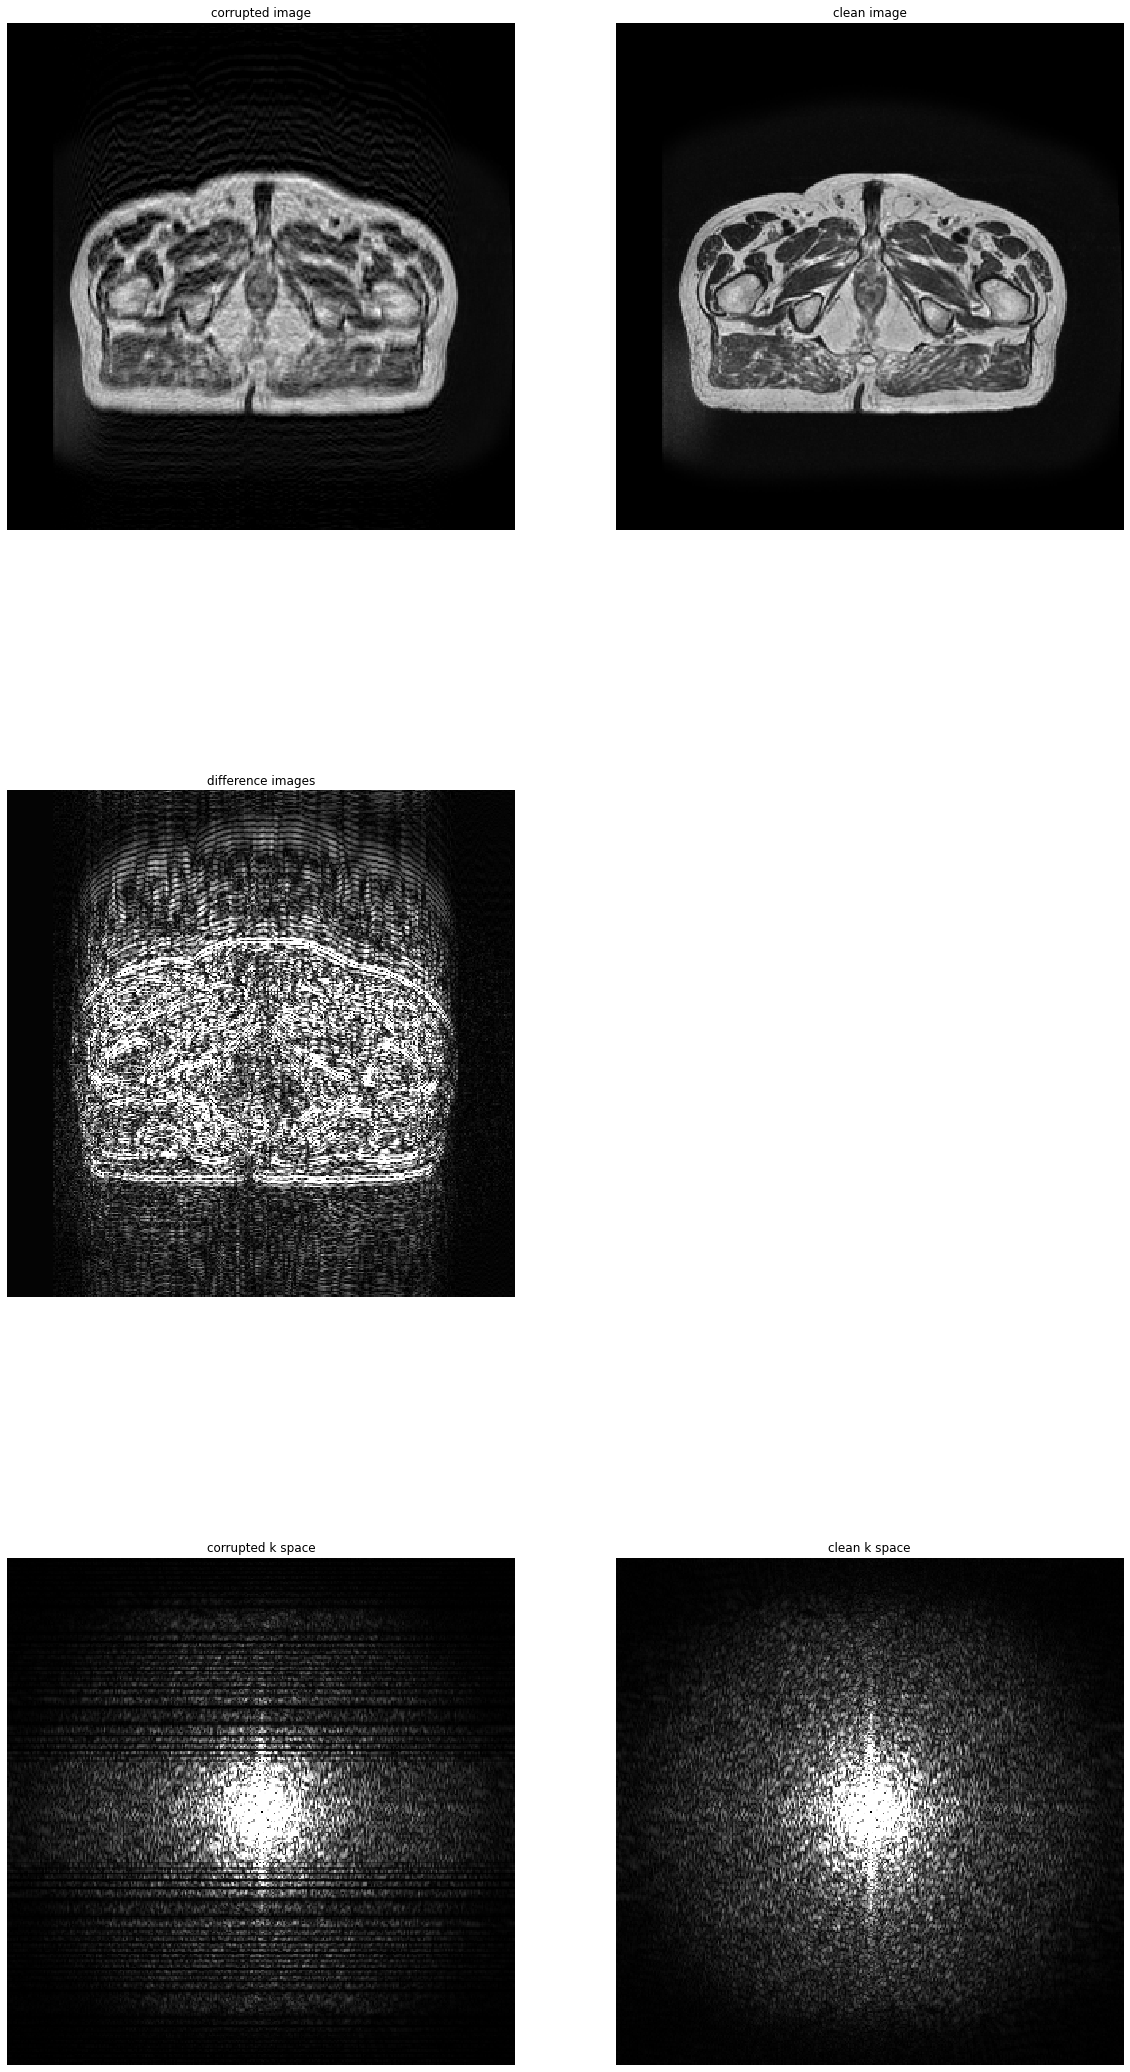

In [13]:
# plotting

img = simulate_breath_sine(image)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [14]:
mean_squared_error(image, img)

0.06234384382623718

In [15]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis'
folders = os.listdir(main_path)
for folder in folders:
    folder_path = main_path + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)

error_motion_image_total = []

for image_path in images_path_list:
    
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    if (image.max() - image.min()) > 1e-5: # skip black images
        image = (image - np.mean(image)) / np.std(image)
        
        for i in range(1):
            img_motion = simulate_breath_sine(image)
            error_motion_image = mean_squared_error(image, img_motion)
            error_motion_image_total.append(error_motion_image)

In [16]:
print('average motion image error: {}'.format(sum(error_motion_image_total)/len(error_motion_image_total)))

average motion image error: 0.05201450277840302
